In [1]:
#Output_file_

In [16]:
!pip install segyio

In [3]:
import segyio
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [4]:
print(torch.cuda.is_available())

True


In [5]:
!pip install pipreqs


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8dffdbcda95531c1786720a23d289e4d967f86d0c1be31c5e0da057680d92dc8
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [5]:

import pipreqs
!pipreqs . --force

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in ./requirements.txt


In [7]:
#Contracting path

In [6]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()

        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.

        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock:
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
# class Contracting_block(nn.Module):
#   ''''ContractingBlock Class Performs two convolutions followed by a max pool operation.
#       Values: input_channels: the number of channels to expect from a given input
#   '''
#   def __init__(self, input_channels):  # Corrected the method name to __init__
#      super(Contracting_block, self).__init__()
#      #Wou want to double the number of channels in the first convolution
#      #and keep the same number of channels in the second.
#      self.conv1 =nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=1)
#      self.conv2 =nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=1)
#      self.activation =nn.ReLU(inplace=True)
#      self.maxpool =nn.MaxPool2d (kernel_size=2, stride=2)
#   def forward(self, x):
#             '''Function for completing a forward pass of ContractingBlock:
#               Given an image tensor, completes a contracting block and returns the transforme Parameters:
#             x: image tensor of shape (batch size, channels, height, width)
#             '''
#             x=self.conv1(x)
#             x=self.activation(x)
#             x=self.conv2(x)
#             x=self.activation(x)
#             x=self.maxpool(x)
#             return x

In [7]:
#unit test
def test_contracting_block(test_samples =1, test_channels=1, test_size=254):
  test_block= ContractingBlock(test_channels)
  test_in= torch.randn(test_samples, test_channels, test_size, test_size)
  test_out_conv1 =test_block.conv1(test_in)
  #Make sure that the first convolution has the right shape
  print(test_out_conv1.shape)

In [8]:
test_contracting_block()

torch.Size([1, 2, 254, 254])


In [11]:
#Expanding path

In [9]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()

        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))

        self.activation = nn.ReLU() # "each followed by a ReLU"

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock:
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection

        Note: In the original Unet implementation, the output shape is smaller than the input, which
        requires a skip connection layer size to be matched with current layer.
        In this application, since our input and output are to be same size, we will note crop the
        skip connection layer. However, there is a placehold commented, if needed in future.

        '''
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [10]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    # Make sure that the first convolution produces the right shape
    print(x.shape)

test_expanding_block()

torch.Size([1, 1024, 64, 64])


In [14]:
#Final Layer

In [11]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet -
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()

        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)


    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock:
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [16]:
#U-Net

In [12]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet:
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs,
        # both with the same number of channels.
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)

        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        return xn

In [13]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


In [ ]:
#Prepare for modelling

In [21]:
# First load datasets

filename_pp = "/content/issap20_Pp.sgy"
filename_ai = "/content/issap20_AI.sgy"
filename_fault = "/content/issap20_Fault.sgy"

In [23]:
# First load datasets

filename_pp = "/content/issap20_Pp.sgy"
filename_ai = "/content/issap20_AI.sgy"
filename_fault = "/content/issap20_Fault.sgy"

# Verify if the files exist at the specified paths
import os
for filename in [filename_pp, filename_ai, filename_fault]:
    if not os.path.exists(filename):
        print(f"Error: File not found: {filename}")
        print("Please ensure the file exists and the path is correct.")
        # You may need to upload the files or adjust the paths accordingly.
        # For example, if the files are in a different directory,
        # update the filenames with the correct paths.
        # For example: filename_pp = "/path/to/your/file/issap20_Pp.sgy"
        break  # Exit the loop if a file is not found

In [26]:
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

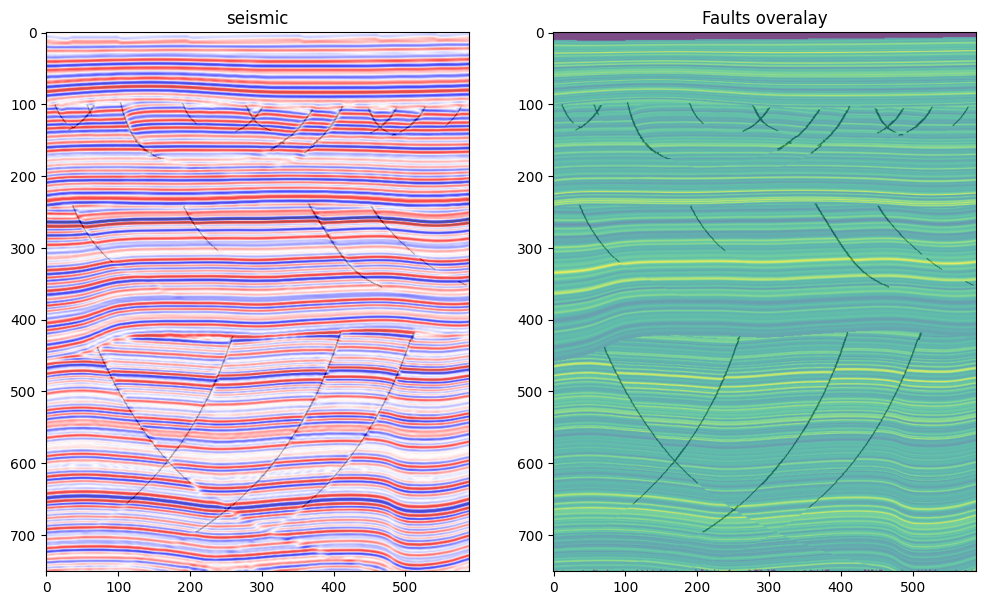

In [27]:
# plot inline
ILINE=10
plt.figure(figsize=(12, 10))
title = ['seismic', 'Faults overalay']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic, ai]):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap=cmaps[i])
    plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()


In [ ]:
#Cropping Input to the shape

In [28]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''

    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]

    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)

    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w]

    return cropped_image

# Function to pad
import torch.nn.functional as F

def pad_to(image, new_shape):
    '''
    Function for padding an image tensor.
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]

    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

In [ ]:
# Some manipulation to get the data into right shape to be input for the UNET model.

'''
Earlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)
The Pytorch implementation requires: (m, n, h, w) shape where,
m = no. of samples (in this case, no. of inlines)
n = number of channel ( 1 for greyscale or single channel)
h, w = 512
By concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.
After that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)
Finally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)
'''

In [29]:
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(101):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))

    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

In [30]:
image_list[0].shape

torch.Size([1, 512, 512])

In [31]:
# Loading data into Pytorch Dataset Utitlity
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [32]:
volumes.shape, labels.shape

(torch.Size([101, 1, 512, 512]), torch.Size([101, 1, 512, 512]))

<ipython-input-33-7ef72fe46a8b>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(volumes[0].T, cmap="gray");


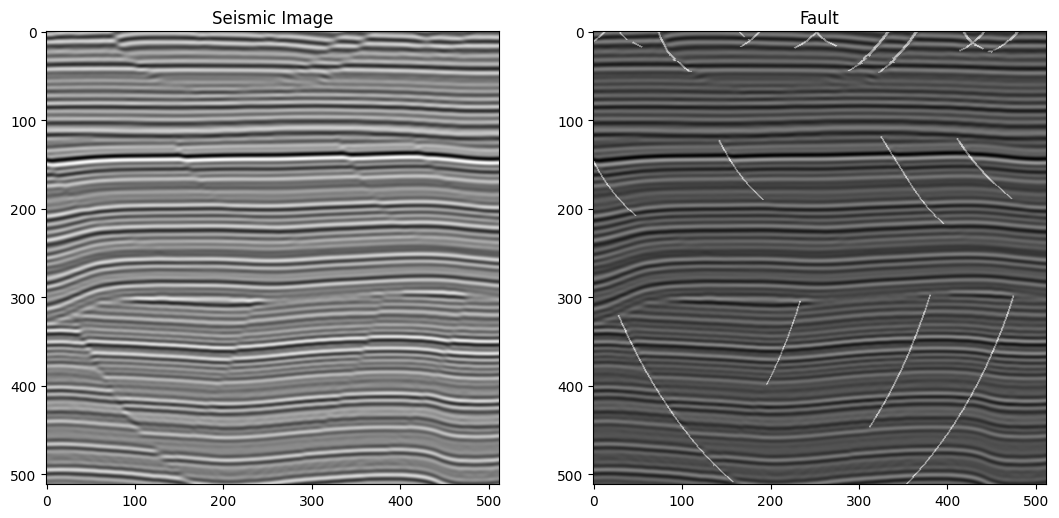

In [33]:
# One last sanity check
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(331)
plt.imshow(volumes[0].T, cmap="gray");
ax.set_title("Seismic Image")

ax = fig.add_subplot(332)
ax.imshow(volumes[0].T, cmap = 'gray')
ax.imshow(labels[0].T, cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
ax.set_title("Fault")
plt.show();

In [34]:
# Special function to display images side by side after training

def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor

    image_unflat = image.detach().cpu()
    fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()


    fig = plt.figure(figsize=(12,15))

    ax = fig.add_subplot(331)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")

    ax = fig.add_subplot(332)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(fault_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")

    ax = fig.add_subplot(333)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(pred_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")

    plt.show()

In [ ]:
# Training
# criterion: the loss function
# n_epochs: the number of times you iterate through the entire dataset when training
# input_dim: the number of channels of the input image
# label_dim: the number of channels of the output image
# display_step: how often to display/visualize the images
# batch_size: the number of images per forward/backward pass
# lr: the learning rate
# initial_shape: the size of the input image (in pixels)
# target_shape: the size of the output image (in pixels)
# device: the device type

In [35]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)


cuda:0


In [36]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 25
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [37]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0

    train_losses = []

    for epoch in range(n_epochs):

        for real, labels in tqdm(dataloader):

            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)


            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            #print(pred.shape)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()


            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))
            cur_step += 1

        train_losses.append(unet_loss)


    return unet, pred, train_losses

In [38]:
# Replace 'cu118' with your desired CUDA version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [39]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")



GPU is available


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.7224894165992737


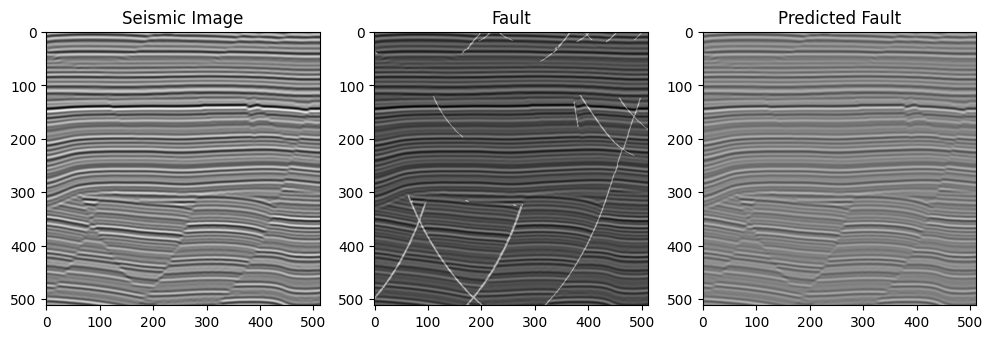

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Step 500: U-Net loss: 0.0792362242937088


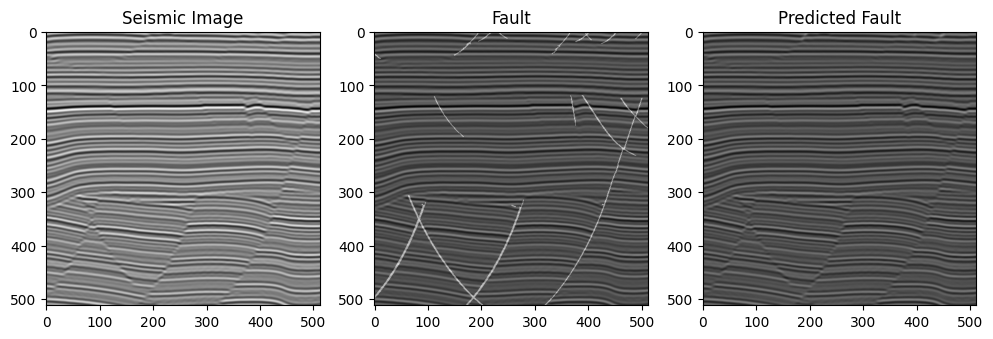

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Step 1000: U-Net loss: 0.01667271926999092


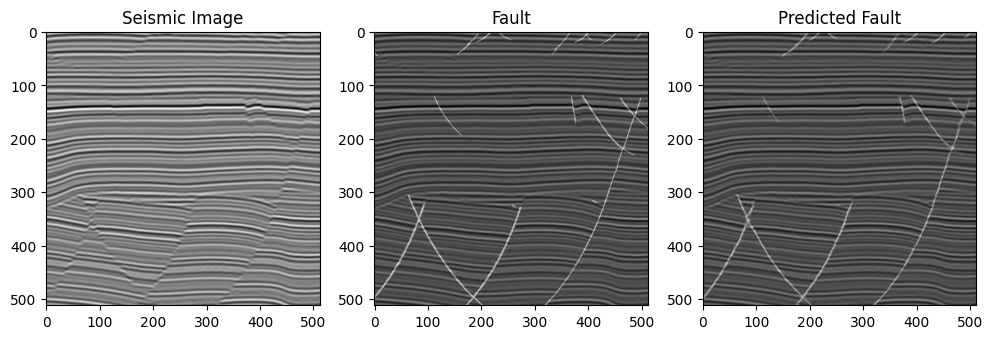

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 14: Step 1500: U-Net loss: 0.01381039060652256


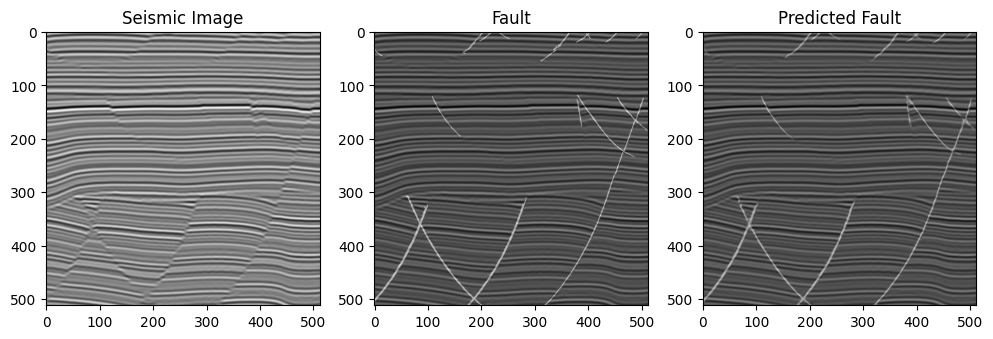

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 19: Step 2000: U-Net loss: 0.01233701128512621


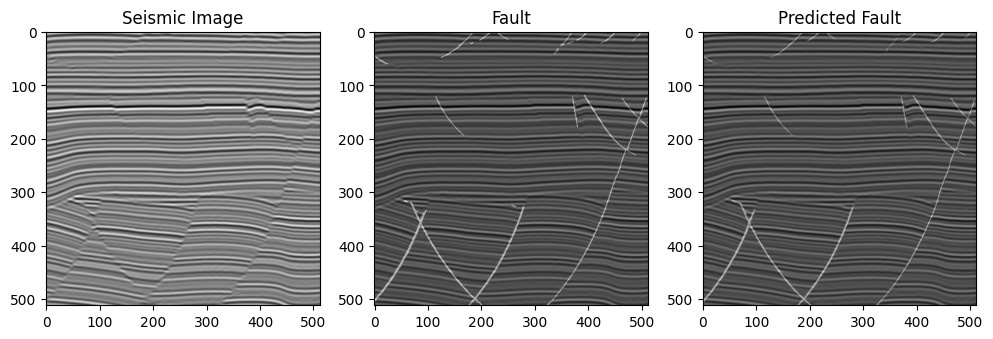

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 24: Step 2500: U-Net loss: 0.011035586707293987


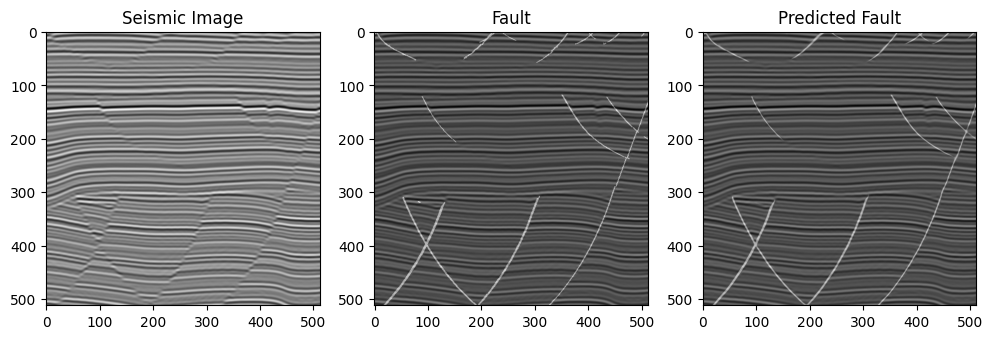

In [40]:
model, pred, loss = train()

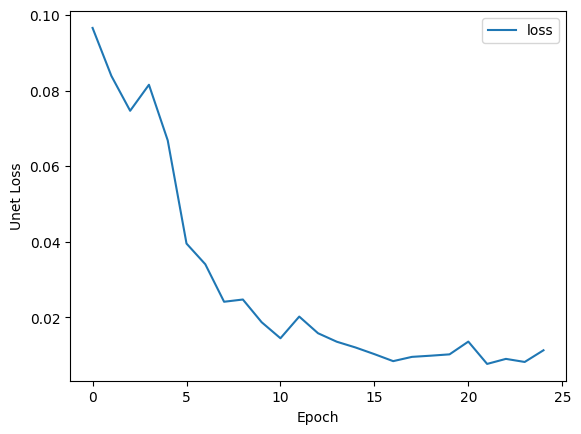

In [43]:
cpu_loss = [item.cpu().detach().numpy() for item in loss]
plt.plot(cpu_loss, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Unet Loss')
plt.legend()
plt.show()